<a href="https://colab.research.google.com/github/MittalNeha/EIP4/blob/master/Assignment4/Assignment4B/ResNet%5B_2_2_2_2%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from keras.utils import np_utils
import matplotlib.pyplot as plt

from keras.layers import GlobalAveragePooling2D

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
input_shape = train_features.shape[1:]

In [0]:
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
depth = 18
version = 1
model_type = 'ResNet%dv%d' % (depth, version)

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        print(x.shape)
        x = conv(x)
        print('num filters = {}'.format(num_filters))
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    # if (depth - 2) % 6 != 0:
    #     raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # # Start model definition.
    num_filters = 64
    # num_res_blocks = int((depth - 2) / 6)

    num_res_blocks = 2
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, num_filters=num_filters)
    # Instantiate the stack of residual units
    # for stack in range(3):
    for stack in range(4):
        print('*********************************')
        for res_block in range(num_res_blocks):
            print('--------------------------------')
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
            print('--------------------------------')
        num_filters *= 2
        print('*********************************')

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = GlobalAveragePooling2D()(x)
    # x = AveragePooling2D(pool_size=4)(x)
    # y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
depth = 18
model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.h5' % model_type
# model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)



(?, 32, 32, 3)

num filters = 64








*********************************
--------------------------------
(?, 32, 32, 64)
num filters = 64
(?, 32, 32, 64)
num filters = 64
--------------------------------
--------------------------------
(?, 32, 32, 64)
num filters = 64
(?, 32, 32, 64)
num filters = 64
--------------------------------
*********************************
*********************************
--------------------------------
(?, 32, 32, 64)
num filters = 128
(?, 16, 16, 128)
num filters = 128
(?, 32, 32, 64)
num filters = 128
--------------------------------
--------------------------------
(?, 16, 16, 128)
num filters = 128
(?, 16, 16, 128)
num filters = 128
--------------------------------
*********************************
*********************************
--------------------------------
(?, 16, 16, 128)
num filters = 256
(?, 8, 8, 256)
num filters = 256
(?, 16, 16, 128)
num filters = 256
--------------------------------
--------------------------------
(?, 8, 8, 256)
n

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=3,
                               min_lr=0.5e-6, monitor='val_loss', verbose=1)
callbacks = [checkpoint, lr_reducer]


In [0]:
from keras.preprocessing.image import ImageDataGenerator
import time

if not data_augmentation:
  model_info = model.fit(train_features, train_labels,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(test_features, test_labels),
              shuffle=True,
              callbacks=callbacks)
else:
  datagen = ImageDataGenerator(zoom_range=0.0, 
                              horizontal_flip=True)
  datagen.fit(train_features)


  # train the model
  start = time.time()
  # Train the model
  model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = batch_size),
                                  samples_per_epoch = train_features.shape[0], nb_epoch = epochs, 
                                  validation_data = (test_features, test_labels), verbose=1, callbacks=callbacks, shuffle=True,)
  end = time.time()

  print ("Model took %0.2f seconds to train"%(end - start))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., shuffle=True, steps_per_epoch=390, epochs=50)`




Epoch 1/50
390/390 [==============================] - 76s 196ms/step - loss: 2.1832 - acc: 0.5430 - val_loss: 2.3832 - val_acc: 0.5054

Epoch 00001: val_acc improved from -inf to 0.50540, saving model to /content/saved_models/cifar10_ResNet18v1_model.h5
Epoch 2/50
390/390 [==============================] - 70s 180ms/step - loss: 1.4818 - acc: 0.7240 - val_loss: 1.5429 - val_acc: 0.6898

Epoch 00002: val_acc improved from 0.50540 to 0.68980, saving model to /content/saved_models/cifar10_ResNet18v1_model.h5
Epoch 3/50
390/390 [==============================] - 71s 181ms/step - loss: 1.2049 - acc: 0.7865 - val_loss: 1.2815 - val_acc: 0.7499

Epoch 00003: val_acc improved from 0.68980 to 0.74990, saving model to /content/saved_models/cifar10_ResNet18v1_model.h5
Epoch 4/50
390/390 [==============================] - 71s 181ms/step - loss: 1.0581 - acc: 0.8162 - val_loss: 1.4422 - val_acc: 0.7089

Epoch 00004: val_acc did not improve from 0.74990
Epoch 5/50
390/390 [========================

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

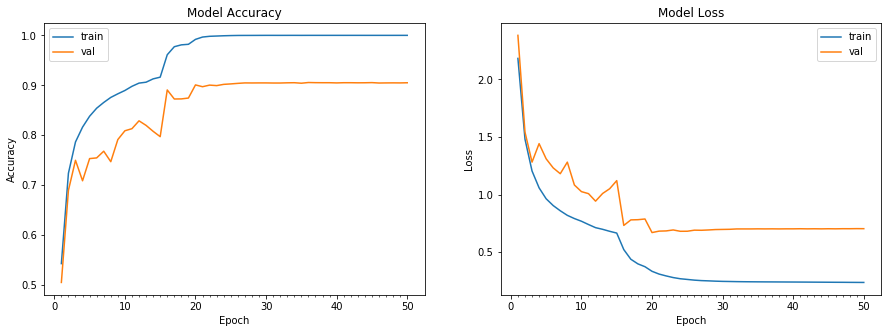

In [0]:
plot_model_history(model_info)

#**Grad CAM**

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

In [0]:
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
model.load_weights(filepath)

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_20")

1


In [0]:
class_output

<tf.Tensor 'strided_slice:0' shape=(?,) dtype=float32>

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 4, 4, 512)
(512,)


In [0]:
pooled_grads

<tf.Tensor 'Mean:0' shape=(512,) dtype=float32>

In [0]:
pooled_grads.shape

TensorShape([Dimension(512)])

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)

In [0]:
np.maximum(heatmap, 0)


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [0]:
conv_layer_output_value.shape

(4, 4, 512)

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(4, 4, 512)
(4, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [0]:
np.max(heatmap)

nan

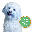

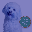

In [0]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)

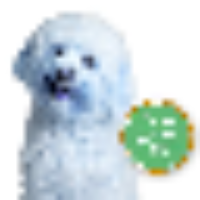

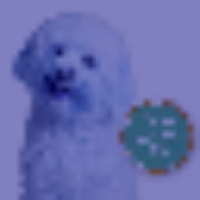

In [0]:
cv2_imshow(cv2.resize(dog, (200, 200)))
cv2_imshow(cv2.resize(superimposed_img, (200, 200)))